前面介绍了解了如何通过对一系列（简单）基函数求和来逼近函数。及展示了 B-splines 基函数的有很多优点。本章将介绍一种类似的方法，但是使用**决策树**而不是 B-splines。    
我们将专注于贝叶斯加性回归树 Bayesian Additive Regression Trees (BART)。它是一个通过对决策树结果求和得到的贝叶斯的非参数模型。它们通常用更接近机器学习术语而不是统计术语的术语来讨论。从某种意义上说，与我们在其他章节中讨论的精心手工制作的模型相比，BART 更像是一种一劳永逸的模型。

## 7.1. 决策树

假设我们有两个变量 $X_1$ 和 $X_2$，并且我们想要使用这些变量将对象分为两类： ⬤ 或 ▲。为了达成这一目标，我们可以使用下图左侧的二叉树形结构来分类，它又可以表示为 if-else 的组合。我们还可以从几何角度将二叉树理解为将样本空间划分为块的一种方式，如右图所示。

![](decision_tree.png)

从数学上描述，我们可以将决策树 $g$ 定义为两个集合：

- $\mathcal{T}$ 是边和节点的集合，以及与内部节点相关的决策规则。
- $\mathcal{M} = \{\mu_1, \mu_2, \dots, \mu_b\}$ 代表 $\mathcal{T}$ 的每个叶节点的平均值。

然后 $g(X; \mathcal{T},  \mathcal{M})$ 就是一个根据 $X$ 输出 $\mu_i$ 的函数。   
    

我们也可将决策树用于回归。
![](decision_tree_reg.png)

回归树不仅限于返回块内数据点的平均值。例如，可以将叶节点与数据点的中位数相关联，或者我们可以对每个块的数据点进行线性回归，甚至更复杂的函数。尽管如此，均值可能是回归树最常见的选择。    

值得注意的是，回归树的输出不是平滑函数，而是分段阶跃函数。这并不意味着回归树一定是拟合平滑函数的糟糕选择。原则上，我们可以用阶跃函数来近似任何连续函数，并且在实践中，这种近似已经足够好了。   
    
决策树的一个吸引人的特点是它的可解释性，您可以逐字阅读树并按照解决某个问题所需的步骤进行操作。因此，您可以清楚地了解该方法正在做什么，为什么它会这样执行，以及为什么某些类可能无法正确分类，或者为什么某些数据的近似值很差。此外，还可以很容易地用简单的术语向非技术受众解释结果。   
    
不幸的是，决策树的灵活性意味着它们很容易过度拟合，因为您总是可以找到一棵足够复杂的树，每个数据点都有一个分区。
![](decision_tree_overfitting.png)

当我们像对待线性模型一样从主效应和相互作用的角度来思考树时，就会出现树的一个有趣的属性：

- 当一棵树仅使用单变量时，它代表此变量的主效应
- 当一棵树使用两个变量时，它代表这两个变量的交互效应

由于树的大小是可变的，我们可以使用树来模拟不同阶的交互效果。随着树变得越来越深，更多变量进入树的机会就会增加，并且代表更高阶交互的潜力也会增加。此外，因为我们使用树的集合（深林），所以我们几乎可以构建主要效果和交互效果的任何组合。

### 7.11.决策树集成

考虑到过于复杂的树可能不太擅长预测新数据，因此通常手段来降低决策树的复杂性并获得更好地适应数据复杂性的拟合。其中一个解决方案依赖于拟合一组树，其中每棵树都被正规化为浅树。因此，每棵树单独只能解释一小部分数据。只有通过组合许多这样的树，我们才能提供正确的答案。这是“联盟使我们强大”座右铭的数据科学化身。 BART 等贝叶斯方法和随机森林等非贝叶斯方法都遵循这种集成策略。一般来说，集成模型可以降低泛化误差，同时保持灵活拟合给定数据集的能力。     
    
使用集成还有助于减轻阶跃性，因为输出是树的组合，虽然这仍然是一个阶跃函数，但它是一个具有更多步骤的函数，因此在某种程度上是一种更平滑的近似。只要我们确保树木足够多样化，情况就是如此。    
    
使用树集合的一个缺点是我们失去了单个决策树的可解释性。现在为了获得答案，我们不能仅仅遵循一棵树，而是很多树，这通常会混淆任何简单的解释。我们用可解释性换取了灵活性和概括性。

## 7.2. BART 模型

如果第5章中的基函数是决策树：

$$
\mathbb{E}[Y] = \phi \left(\sum_{j=0}^m g_j(\boldsymbol{X}; \mathcal{T}_j, \mathcal{M}_j), \theta \right)
$$

其中 $g_j$ 是第 $j$ 棵树，$\mathcal{T}_j$ 和 $\mathcal{M}_j$ 是树的结构和叶节点的平均值。$\phi$ 是似然分布，$\theta$ 是 $\phi$ 的参数向量。   
    
例如，如果我们使用正态分布作为 $\phi$：
$$
Y = \mathcal{N}\left(\mu = \sum_{j=0}^m g_j(\boldsymbol{X}; \mathcal{T}_j, \mathcal{M}_j), \sigma \right)
$$    
    
或者我们也可以使用泊松分布：
$$
Y = \text{Pois}\left(\lambda = \sum_{j}^m g_j(\boldsymbol{X}; \mathcal{T}_j, \mathcal{M}_j)\right)
$$
或者使用学生分布：
$$
Y = \text{T}\left(\mu = \sum_{j}^m g_j(\boldsymbol{X}; \mathcal{T}_j, \mathcal{M}_j), \sigma, \nu \right)
$$

与之前一样，BART 建模需要选择先验分布。

## 7.3. BART 的先验分布
原始的 BART 论文，以及大多数后续的修改和实现都依赖于共轭先验。然而，PyMC 中的 BART 实现并未使用共轭先验，并且在其他方面也有所不同。我们将不讨论这些差异，而是专注于 PyMC 的实现，这是我们将用于示例的实现。

### 7.3.1. 独立先验
为了简化先验，我们可以假设每棵树 $\mathcal{T}_i$ 及每个叶子 $\mathcal{M}_j$ 各自之间都是独立的，并且与参数 $\theta$ 也是独立的。通过假设独立性，我们可以将先前的规范分成几个部分。

### 7.3.2. 树结构 $\mathcal{T}$ 的先验

树结构 $\mathcal{T}_j$ 的先验由三个方面指定：

- 在深度 $d=(0, 1, 2, \dots)$ 的节点是非终端的概率，由 $\alpha^{d}$ 给出。建议 $\alpha$ 的值在 $[0, 0.5)$ 范围内。

- 分裂变量的分布。也就是说，哪个协变量（$X_i$）被包含在树中。最常见的是在可用的协变量上均匀分布。

- 分裂规则的分布。也就是说，一旦我们选择了一个分裂变量，我们使用哪个值来做决定。这通常在可用的值上均匀分布。

### 7.3.3. 叶节点值 $\mu_{ij}$ 和树数量 $m$ 的先验

默认情况下，PyMC 不会为叶节点值设置先验值，而是在采样算法的每次迭代中返回残差的均值。

关于集成中树的数量 $m$。这也通常由用户预先定义。在实践中，人们观察到通过设置 $m=200$ 或甚至低至 $m=10$ 的值，通常可以获得良好的结果。此外，人们还观察到推理可能对 $m$ 的确切值非常鲁棒。因此，一个通用的经验法则是尝试几个 $m$ 的值，并进行交叉验证以选择最适合特定问题的值。

## 7.4. 拟合贝叶斯加性回归树

为了拟合 BART 模型，我们不能使用基于梯度的采样器，如 Hamiltonian MonteCarlo，因为树的空间是离散的，因此不是 *梯度友好* 的。因此，研究人员已经开发了专门针对树的 MCMC 和 Sequential Monte Carlo (SMC) 变体。    
PyMC3 中实现的 BART 采样器以顺序和迭代的方式工作。简单来说，我们从一棵树开始，将其拟合到 $Y$ 响应变量，然后计算残差 $R$，即 $R = Y - g_0(\boldsymbol{X}; \mathcal{T}_0, \mathcal{M}_0)$。第二棵树是拟合到 $R$，而不是 $Y$。然后我们通过考虑到目前为止拟合的树的总和来更新残差 $R$，因此 $R - g_1(\boldsymbol{X}; \mathcal{T}_0, \mathcal{M}_0) + g_0(\boldsymbol{X}; \mathcal{T}_1, \mathcal{M}_1)$，我们继续这样做，直到我们拟合了 $m$ 棵树。  

这个过程将产生后验分布的一个样本，一个有 $m$ 棵树的样本。注意，这第一次迭代很容易导致次优的树，主要原因是：首次拟合的树倾向于比必要的更复杂，树可能会陷入局部最小值，最后，后来的树的拟合受到前面的树的影响。所有这些效应都会随着我们继续采样而消失，因为采样方法将多次重新访问先前拟合的树，并给它们机会重新适应更新的残差。实际上，拟合 BART 模型时的一个常见观察是，树在前几轮倾向于更深，然后它们会崩溃成更浅的树。

在文献中，特定的 BART 模型通常是针对特定的采样器定制的，因为它们依赖于共轭性，因此，具有高斯似然的 BART 模型与具有泊松似然的模型是不同的。PyMC 使用基于 Particle Gibbs 的采样器，该采样器专门用于处理树。PyMC 将自动将此采样器分配给 `pm.BART` 分布，如果模型中存在其他随机变量，PyMC 将为这些变量分配其他采样器，如 NUTS。

## 7.5. BART 单车模型

基于 BART 对之前的单车数据集建模：
$$
\begin{aligned}
\begin{split}
    \mu \sim& \; \text{BART}(m=50) \\
    \sigma \sim& \; \mathcal{HN}(1) \\
    Y \sim& \; \mathcal{N}(\mu, \sigma)
\end{split}\end{aligned}
$$

在 PyMC 中构建 BART 模型与构建其他类型的模型非常相似，一个区别是指定随机变量 `pm.BART` 需要知道自变量和因变量。主要原因是用于拟合 BART 模型的采样方法在残差方面提出了一种新的树，如上一节所述。

In [1]:
%matplotlib inline
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import arviz as az
from scipy.special import expit

from pdp import plot_pdp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [22]:
az.style.use('arviz-grayscale')
plt.rcParams["figure.dpi"] = 300
np.random.seed(5453)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

In [23]:
data = pd.read_csv("../data/bikes_hour.csv")
data = data[::50]
data.sort_values(by='hour', inplace=True)
data.hour.values.astype(float)

X = np.atleast_2d(data["hour"]).T
Y = data["count"]

In [24]:
import pymc_bart as pmb

with pm.Model() as bart_g:
    σ = pm.HalfNormal('σ', Y.std())
    μ = pmb.BART('μ', X, Y, m=50)
    y = pm.Normal('y', μ, σ, observed=Y)
    idata_bart_g = pm.sample(2000, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 94 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


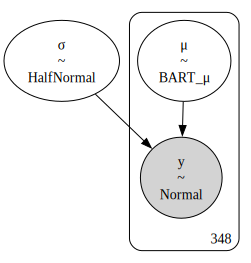

In [25]:
pm.model_to_graphviz(bart_g)

在展示拟合结果之前需要对中间步骤略微解释一下。这会帮助我们理解 BART 模型的工作原理。
![](BART_bikes_samples.png)

上图显示了从模型计算出的后验中采样的树。    
在顶部，我们有三棵独立的树，出自 `m=50` 棵树。树返回的实际值是实心点，线是连接它们的视觉辅助线。数据的范围（每小时租赁的自行车数量）大约在每小时租赁 0-800 辆自行车的范围内。因此，即使图形省略了数据，我们也可以看到，拟合相当粗糙，这些分段函数在数据的规模上大多是平的。这是我们讨论树是 *弱学习者* 的预期结果。鉴于我们使用了高斯似然，模型允许负计数值。    
在底部面板上，我们有来自后验的样本，每个样本都是 $m$ 颗树的和。

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'count')

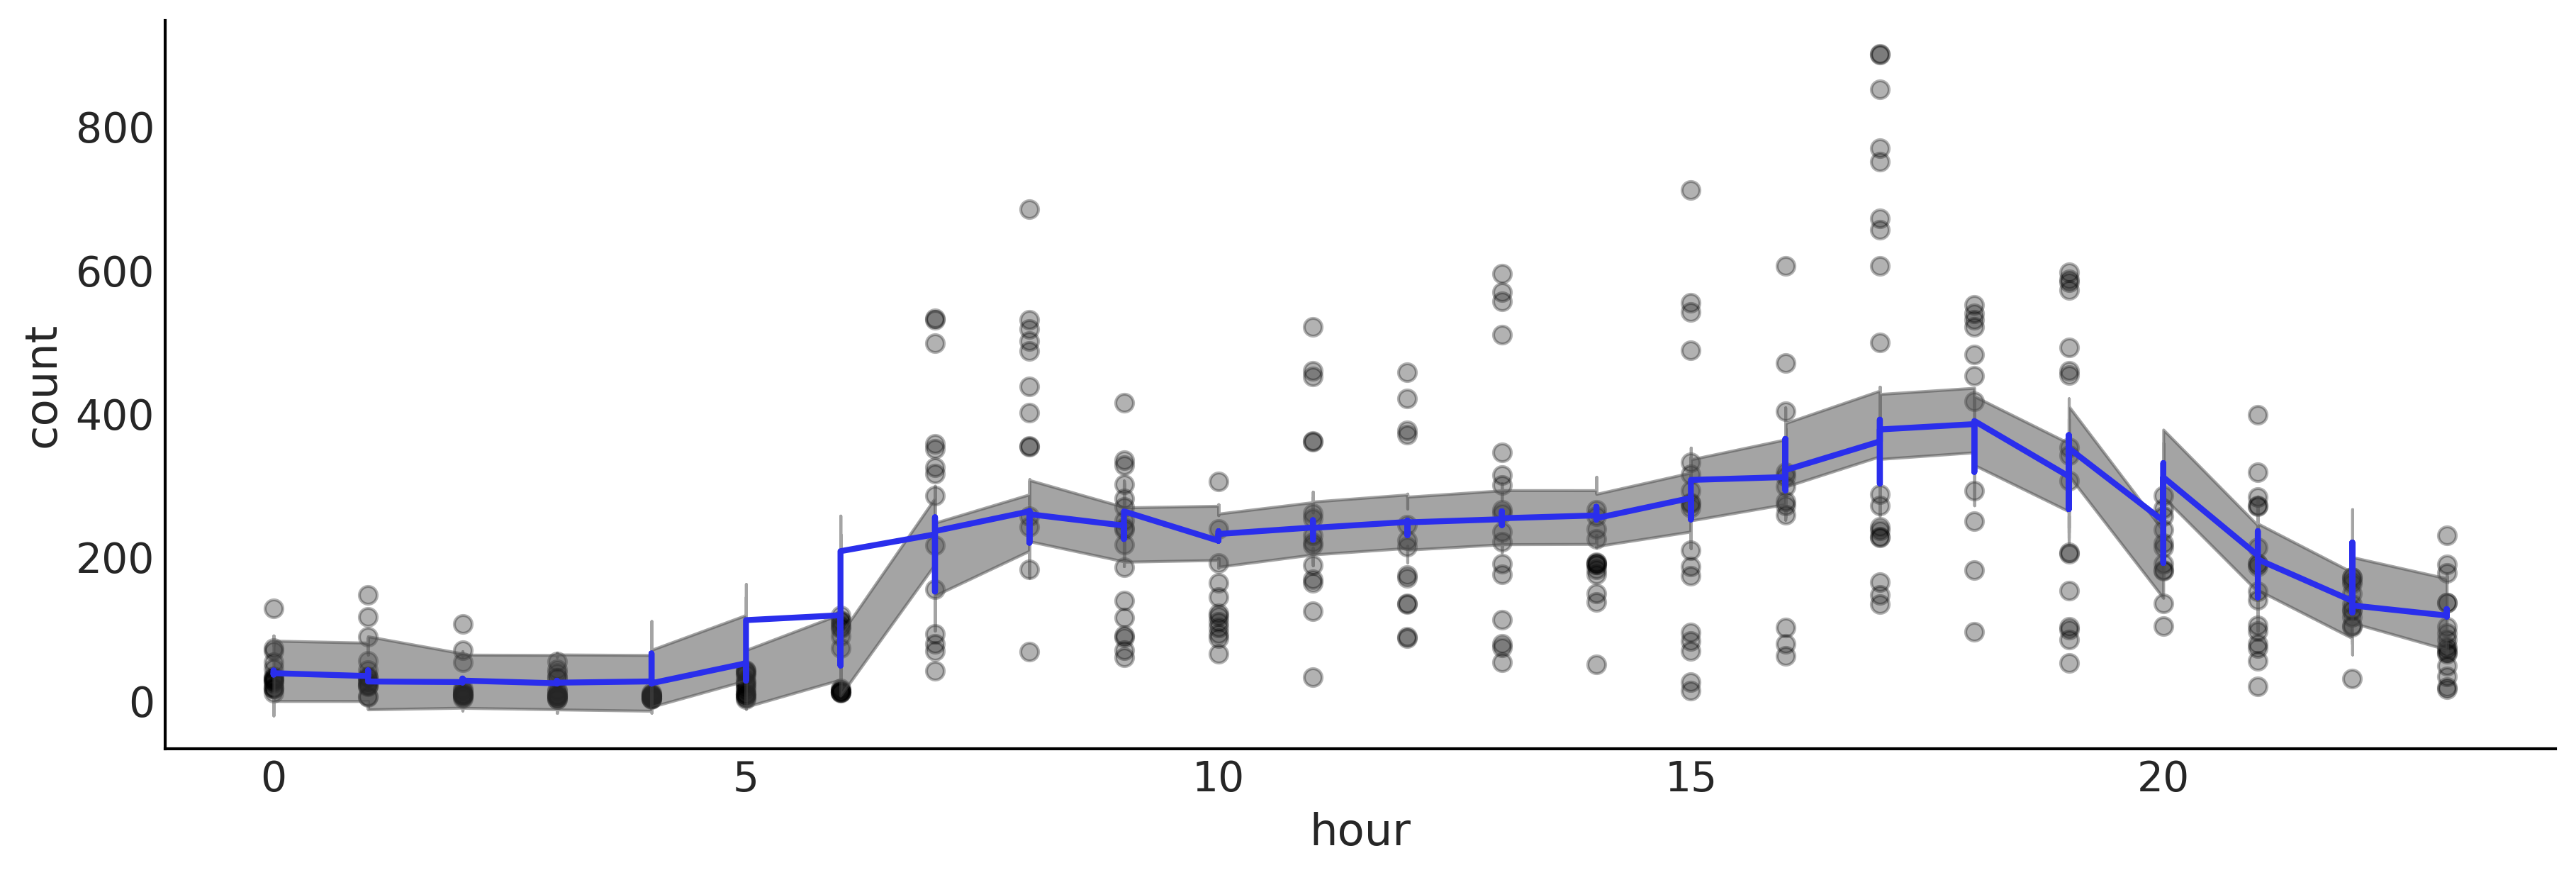

In [26]:
posterior = idata_bart_g.posterior.stack(samples=("chain", "draw"))

_, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(X, Y, "o", alpha=0.3, zorder=-1)
ax.plot(X,  posterior["μ"].mean("samples"), color="C4", lw=2)
az.plot_hdi(X[:,0], posterior["μ"].T, smooth=False)


ax.set_xlabel("hour")
ax.set_ylabel("count")

**`toFix`**：上图看到拟合的比较差，部分区域后验结果的均值在HDI之外，说明有大离群值影响。为啥换了新版本后，与原书会差这么多？

上图是 BART 的拟合结果，其与 splines 的结果相似，但是明显锯齿状部分更多，HDI 的宽度也有差异。    
    
围绕 BART 的文献倾向于强调其通常能够提供有竞争力的答案而无需调参的能力。例如，与拟合样条相比，我们不需要担心手动设置节点或选择先验来规范节点。当然，有人可能会争辩说，对于某些问题，能够调整节点可能对手头的问题有益。

## 7.6. 广义 BART 模型

BART 的 PyMC 实现让使用不同的似然性变得容易，类似于我们在第 3 章中看到的广义线性模型的做法。让我们看看如何在 BART 中使用伯努利似然。    
在本示例中，我们将使用虚构的太空流感疾病的数据集，该疾病主要影响年轻人和老年人，但不影响中年人。在此数据集中，我们记录了接受过太空流感检测的人员以及他们是否患病 (1) 或健康 (0) 以及他们的年龄。与上一个模型对比，我们会发现差异很小：
```python
with pm.Model() as model:
    μ = pmb.BART("μ", X, Y, m=50)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    y = pm.Bernoulli("y", p=θ, observed=Y)
    trace = pm.sample(2000, return_inferencedata=True)
```

不同之处在于，我们使用了 `pm.Bernoulli` 分布，而不是 `pm.Normal` 分布。我们还使用了 `pm.math.sigmoid` 函数，将 BART 的输出转换为概率。以下我们试试调整 $m$ 并比较模型：

In [28]:
space_in = pd.read_csv("../data/space_influenza.csv")
X = np.atleast_2d(space_in["age"]).T
Y = space_in["sick"]


Y_jittered = np.random.normal(Y, 0.02)

In [8]:
traces = []
ntrees = [2, 10, 20, 50]
for ntree in ntrees:
    with pm.Model() as bart_b:
        μ = pmb.BART('μ', X, Y, m=ntree)
        θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
        y = pm.Bernoulli('y', θ, observed=Y)
        loglik = pm.Deterministic('log_likelihood', pm.logp(y, Y))
        idata_bart_b = pm.sample()
        traces.append(idata_bart_b)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [9]:
for model in traces:
    model.add_groups({"log_likelihood": {"y":model.posterior.log_likelihood}})

In [10]:
dict_cmp = dict(zip(("2", "10", "20", "50"), traces))
cmp = az.compare(dict_cmp)
cmp

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
50,0,-56.463001,3.052620,0.00000,1.000000e+00,6.440583,0.000000,False,log
20,1,-62.232461,5.622886,5.76946,0.000000e+00,6.475465,0.368794,False,log
10,2,-70.506661,9.582893,14.04366,0.000000e+00,6.349136,0.792405,False,log
2,3,-114.131600,27.957099,57.66860,6.643575e-11,5.213074,2.566919,False,log


/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

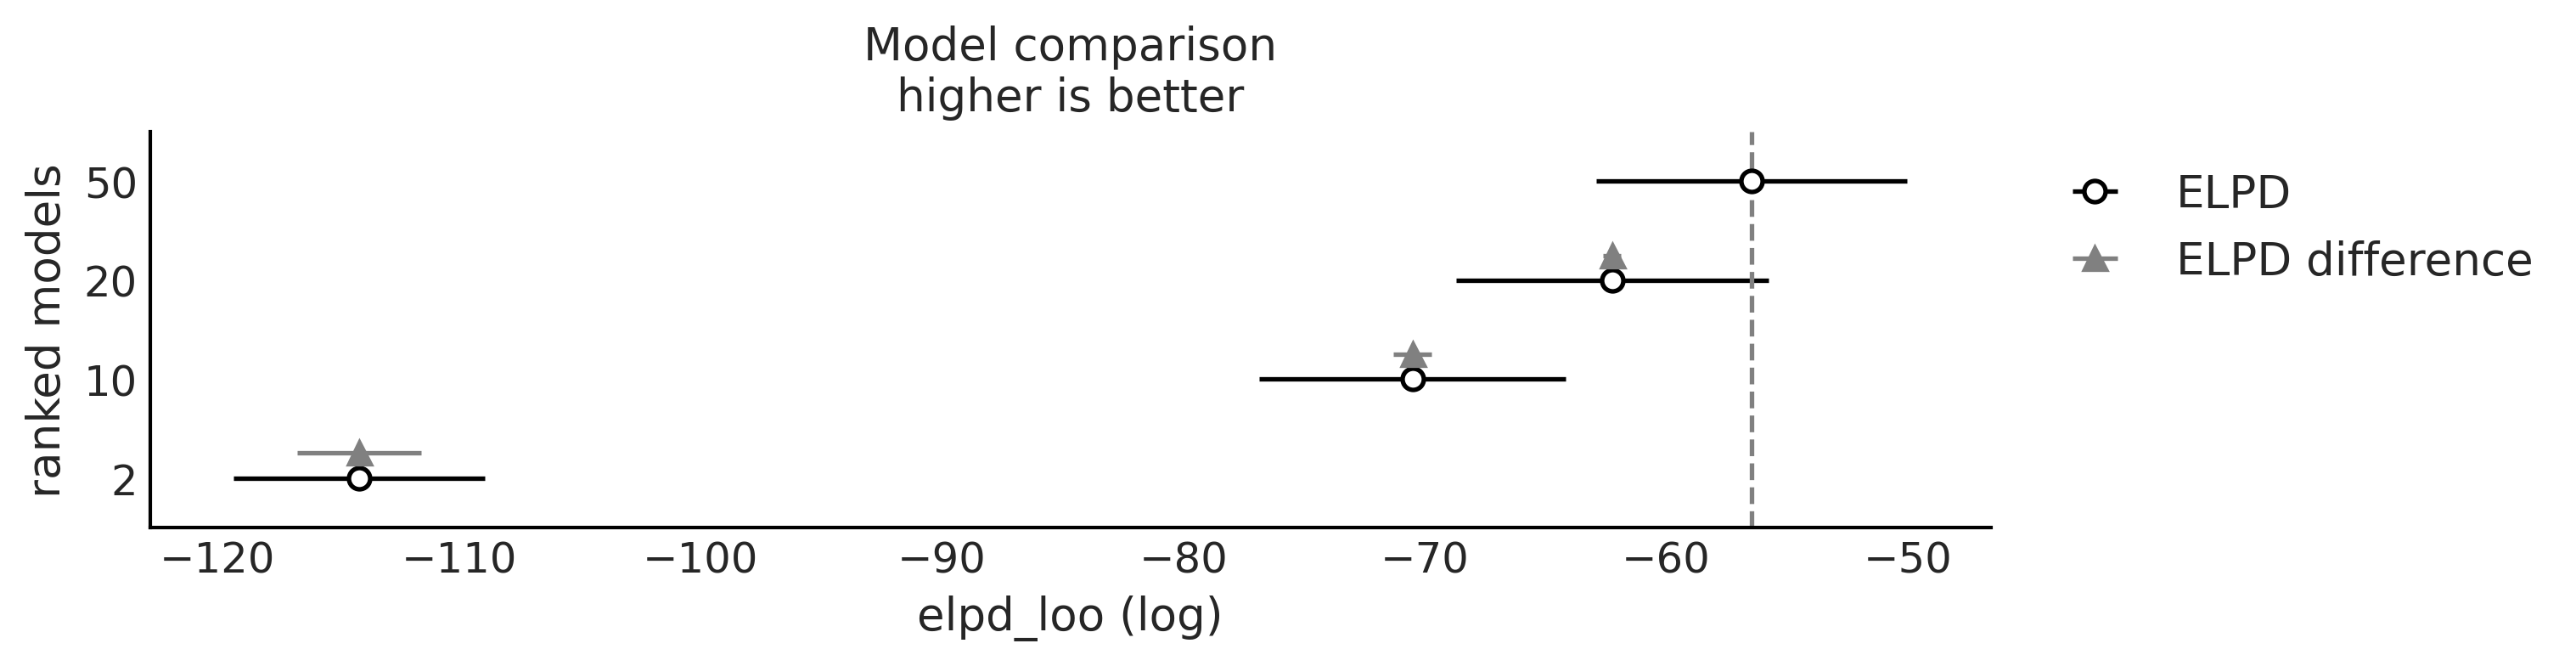

In [11]:
az.plot_compare(cmp, figsize=(10, 2.5))

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **h

Text(-0.03, 0.5, 'Space Influenza')

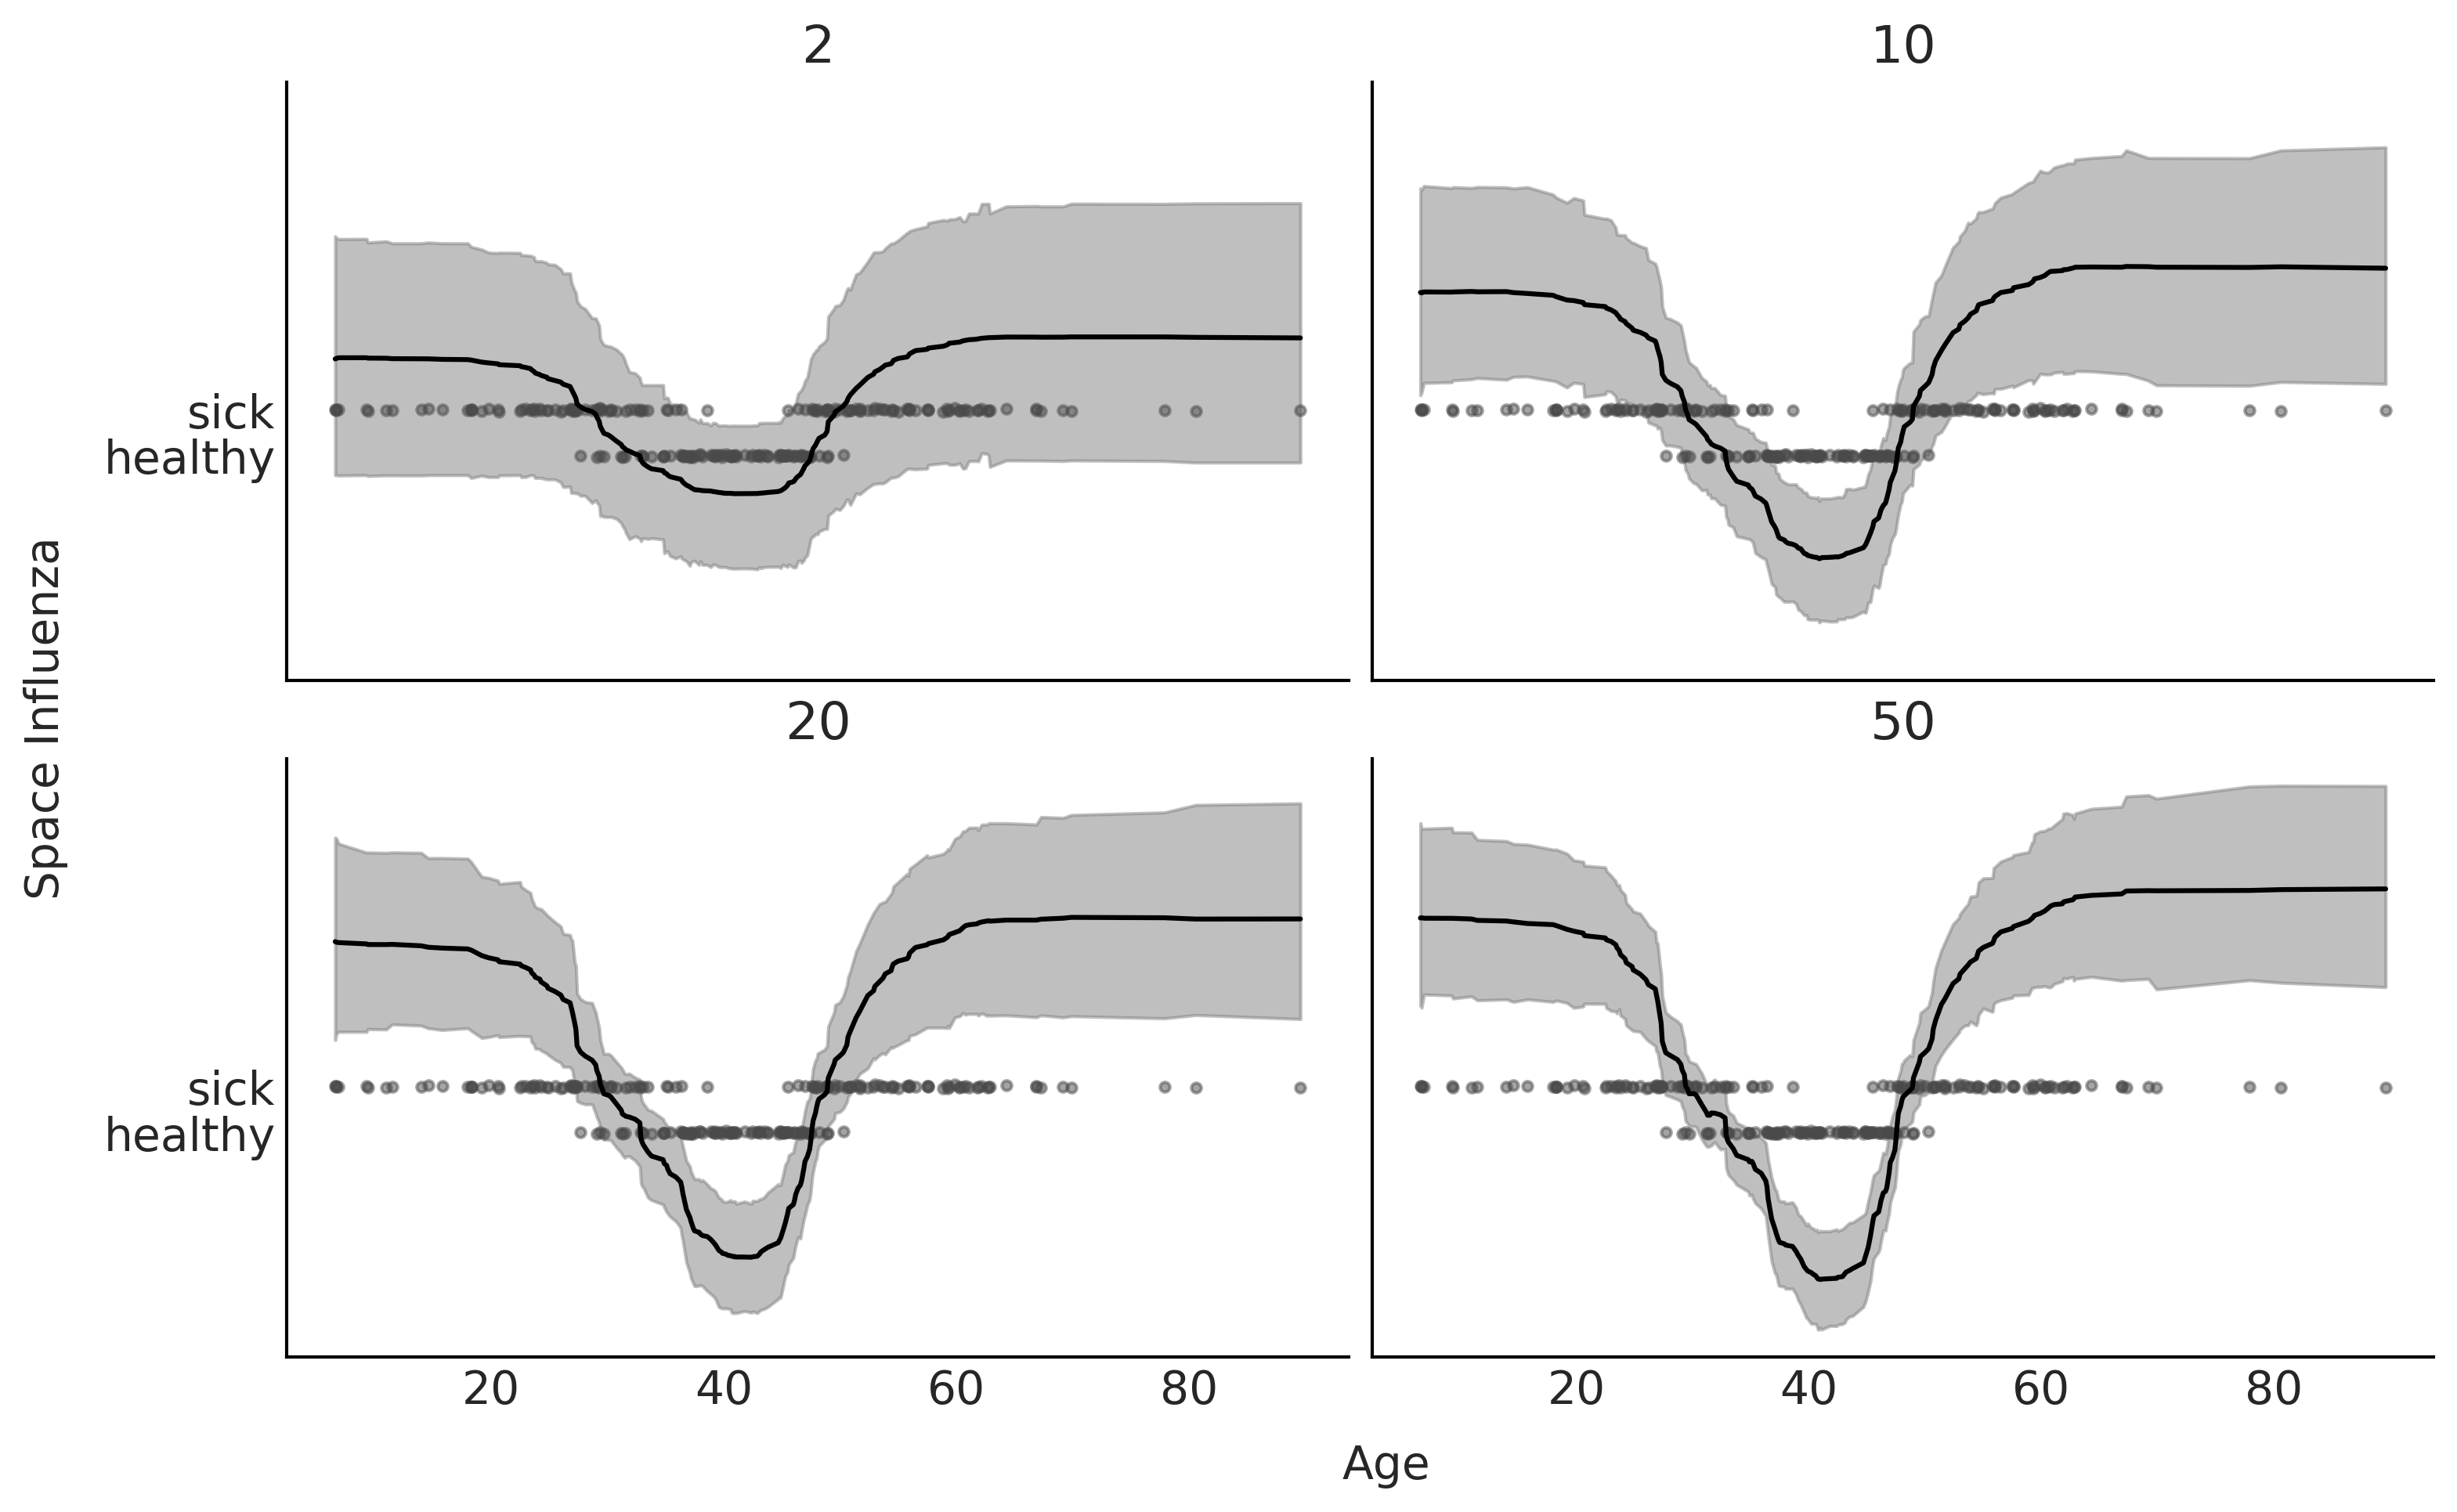

In [12]:
fig, axes = plt.subplots(2,2, figsize=(10, 6), sharey=True, sharex=True)

for ax, trace, mtree in zip(np.ravel(axes), traces, ntrees):
    μs = trace.posterior["μ"].stack({"draws":["chain",  "draw"]})

    ax.plot(X, Y_jittered, "C1.", alpha=0.5)

    X_idx = np.argsort(X[:,0])
    ax.plot(X[:,0][X_idx], np.mean(μs, 1)[X_idx], 'k-') 
    
    az.plot_hdi(X[:,0], μs.T, ax=ax, smooth=False, color="0.5") # una banda con el 94% Highest Density Interval
    ax.set_title(mtree)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["healthy", "sick"])
fig.text(0.55, -0.04, 'Age', ha='center', size=14)
fig.text(-0.03, 0.5, 'Space Influenza', va='center', size=14, rotation=90)

**`toFix`**：二分类问题用BART后上拟合的很差，能查到类似的问题没有解决 [Binary classification example using the recently added BART model](https://discourse.pymc.io/t/binary-classification-example-using-the-recently-added-bart-model/6420/4)

到目前为止，我们已经讨论了单个协变量的回归。然而，可以用更多协变量来拟合数据集。从 PyMC 的实现角度来看这很简单，我们只需要传递一个包含超过 1 个协变量的 $X$ 二维数组。但它提出了一些有趣的统计问题，例如如何轻松解释具有许多协变量的 BART 模型，或者如何找出每个协变量对结果的贡献程度。在接下来的部分中，我们将展示这是如何完成的。

## 7.7. BART 的解释性

单个决策树通常易于解释，但当我们将一堆树加在一起时，这就不再成立了。原因是通过添加树，我们得到了一些奇怪的、无法识别或难以描述的对象，但实际上，树的总和只是另一棵树。解释这个 *集成* 树的难度在于，对于一个复杂的问题决策规则将难以理解。

我们仍然可以通过直接检查树的总和来获得一些有用的信息，但不如单个简单的树那样透明或有用。因此，为了帮助我们解释 BART 模型的结果，我们通常依赖于模型诊断工具。例如，也用于多元线性回归和其他非参数方法的工具。我们将在下面讨论两个相关的工具：**部分依赖图** (PDP) 和 **个体条件期望** (ICE) 图。


### 7.7.1. 部分依赖图 Partial Dependence Plots
BART 文献中出现的一种非常常见的方法是所谓的部分依赖图 (PDP)。 PDP 显示了某协变量变动，其余协变量固定为其边际分布均值时，预测变量的值如何变化。也就是说，我们计算然后绘制：

$$
\tilde{Y}_{\boldsymbol{X}_i}= \mathbb{E}_{\boldsymbol{X}_{-i}}[\tilde{Y}(\boldsymbol{X}_i, \boldsymbol{X}_{-i})] \approx \frac{1}{n}\sum_{j=1}^{n} \tilde{Y}(\boldsymbol{X}_i, \boldsymbol{X}_{-ij})
$$

其中 $\tilde{Y}_{\boldsymbol{X}_i}$ 是其它变量固定后 $\boldsymbol{X}_i$ 的预测结果。一般来说，$X_i$ 将是 1 或 2 个变量的子集，原因是在更高维度上绘图通常很困难。    

如方程所示，期望可以是通过对预测值进行平均来进行数值近似 以观察到的 $\boldsymbol{X}_{-i}$ 为条件。但请注意，这意味着其中的一些组合 $\boldsymbol{X}_i, \boldsymbol{X}_{-ij}$ 可能与实际不符。

![](partial_dependence_plot.png)

### 7.7.2. 个体条件期望图 Individual Conditional Expectation Plots

个体条件期望（Individual Conditional Expectation，ICE）图与PDP紧密相关。区别在于，ICE图不是绘制目标协变量对预测响应的平均偏效果，而是绘制 $n$ 个估计的条件期望曲线。换句话说，ICE图中的每条曲线反映了在固定 $\boldsymbol{X}{-ij}$ 的情况下，关于协变量 $\boldsymbol{X}{i}$ 的部分预测响应。示例见下图，如果我们在每个 $\boldsymbol{X}_{ij}$ 值上对所有灰色曲线取平均，就得到蓝色曲线：

![](individual_conditional.png)

## 7.8. 选择变量

当拟合具有多个预测因子的回归时，我们通常会对了解哪些预测因子最重要感兴趣。BART 模型提供了一种非常简单，几乎无需计算的启发式方法来估计变量的重要性。它跟踪了一个协变量被用作分割变量的次数。例如如果我们有两个分割节点，一个包括变量 $X_1$，另一个包括 $X_2$，所以基于这棵树，这两个变量同样重要。如果相反，我们将 $X_1$ 计数两次，$X_2$ 计数一次。我们会说 $X_1$ 的重要性是 $X_2$ 的两倍。对于 BART 模型，变量的重要性是通过对 $m$ 棵树和所有后验样本进行平均来计算的。请注意，使用这种简单的启发式方法，我们只能以相对的方式报告重要性，因为没有简单的方法可以说这个变量是重要的，这个另一个变量不重要。    
    
进一步可以将重要性正则化，每个值处于[0, 1]之间，总和为1。但是依然需要注意，以上并没有很好的理论基础，只是一种启发式方法。    
    
以下通过三种生成过程产生的数据集：

-   $Y \sim \mathcal{N}(0, 1)$, $X_{0} \sim \mathcal{N}(Y, 0.1)$, 
    $X_{1} \sim \mathcal{N}(Y, 0.2)$, 
    $\boldsymbol{X}_{2:9} \sim \mathcal{N}(0, 1)$. 只有前两个变量与 $Y$ 相关，且 $X_0$ 的影响更大。

-   $Y = 10 \sin(\pi X_0 X_1 ) + 20(X_2 - 0.5)^2 + 10X_3 + 5X_4 + \epsilon$, 
    其中 $\epsilon \sim \mathcal{N}(0, 1)$ ,
    $\boldsymbol{X}_{0:9} \sim \mathcal{U}(0, 1)$。注意只有前5个变量与 $Y$ 相关。

-   $\boldsymbol{X}_{0:9} \sim \mathcal{N}(0, 1)$ , 
    $Y \sim \mathcal{N}(0, 1)$. 所有变量都与 $Y$ 无关。

![](bart_vi_toy.png)

从上图可见，当 $m$ 增大后各因子的重要性变得更平。从直觉上来解释，如果我们增加树的个数，单棵树的预测能力下降，导致不相关的变量有更高的机会成为树的一部分。    


## 7.9. BART 的先验

与本书中其它模型相比， BART 是最黑盒的。我们无法设置先验，只能通过参数控制几个预设的先验：

- `m`：树的数量
- `alpha`：树的深度
- 分割变量的分布

我们观察到改变树的数量的效果，已经证明对于值在50-200之间的稳健预测是有效的。此外，有许多例子表明使用交叉验证来确定这个数量是有益的。我们还观察到，通过扫描相对较低的 $m$ 值，例如在25-100的范围内，我们可以评估变量的重要性。我们没有费心去改变默认值$\alpha=0.25$，因为这种改变似乎影响更小，尽管仍需要进一步研究来更好地理解这个先验分布。与$m$一样，交叉验证也可以用于调整$\alpha$以获得更好的效率。最后，PyMC3提供了传递权重向量的选项，因此不同的变量具有不同的先验选择概率。当用户有证据表明某些变量可能比其他变量更重要时，这可能是有用的，否则最好保持均匀分布。已经提出了更复杂的基于狄利克雷分布的先验分布，以实现这一目标，并在需要诱导稀疏性时允许更好的推断。这在我们有许多协变量，但只有少数可能对结果产生影响并且我们事先不知道哪些变量最相关的情况下非常有用。这在遗传研究中是一个常见情况，例如，测量数百个或更多基因的活性相对容易，但它们之间的关系不仅不为人所知，而且也是研究的目标。

大多数BART实现是在特定的软件包中进行的，有些甚至是针对特定的子学科。它们通常不是概率编程语言的一部分，因此不需要用户过多调整BART模型。因此，即使可以直接对树的数量设置先验，实际上通常并不是这样做的。相反，BART文献赞扬了BART在默认参数下的良好性能，同时承认可以使用交叉验证来获得额外的效果。PyMC3中的BART实现与这种传统稍有不同，并允许一些额外的灵活性，但与我们使用其他分布（如高斯或泊松分布）或非参数分布（如高斯过程）的方式相比，仍然非常有限。我们预计在不久的将来这种情况可能会发生变化，部分原因是我们对探索更灵活的BART实现感兴趣，这样用户就可以构建灵活且量身定制的模型，就像概率编程语言通常的情况一样。